In [2]:
from __future__ import (division, print_function, absolute_import, unicode_literals)
import os
from satpy import Scene
from glob import glob
import rioxarray
import sqlite3
import numpy as np
import sys
import os
import os.path
import shutil
import time
import json
import os
from datetime import datetime, timedelta
from goes2go.data import goes_nearesttime
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import netCDF4
import leafmap  # Add this import
from io import StringIO
USERAGENT = 'tis/download.py_1.0--' + sys.version.replace('\n','').replace('\r','')
from datetime import datetime, timedelta

In [66]:
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import rioxarray
from rasterio.plot import show

In [4]:
def get_VIIRS_bounds_polygon(VIIRS_fire_path):
    """
    Get a VIIRS fire product path return a polygon of VIIRS image bounds

    :VIIRS_fire_path: VIIRS fire product for example "C:\\Asaf\\VIIRS\\VNP14IMG.A2020251.2042.001.2020258064138"

    :return: geodataframe of bounds in lat/lon WGS84 projection
    """
    VIIRS = xr.open_dataset(VIIRS_fire_path)  ## Open file
    ## Now for the bbox bounds
    lat_bounds = VIIRS.attrs['GRingPointLatitude']
    lon_bounds = VIIRS.attrs['GRingPointLongitude']

    pol_bounds = []  ## Empty bounds list
    for i in range(len(lat_bounds)):  ## for all bounds
        coord = (lon_bounds[i], lat_bounds[i])  ## Take lon/lat
        pol_bounds.append(coord)  ## append
    pol_bounds.append((lon_bounds[0], lat_bounds[0]))  ## append firt coords to "close" the polygon

    pol = shapely.Polygon(pol_bounds)  ## Create polygon
    gdf_pol = gpd.GeoDataFrame({'geometry': [pol]}, crs=4326)  ## Create as gdf

    return (gdf_pol)

In [38]:
viirs_bound_poly = get_VIIRS_bounds_polygon(r"C:\Users\Admin\Desktop\6.3.25\2020-02-20_19-54\VNP02IMG.A2020051.1954.002.2021126151822.nc")

In [39]:
viirs_bound_poly.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
AOY_PATH = r"C:\Users\Admin\Desktop\6.3.25\boundary_gdf.shp"

In [41]:
AOI = gpd.read_file(AOY_PATH)
AOI.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [42]:
if AOI.crs == viirs_bound_poly.crs:
    print(viirs_bound_poly.contains(AOI))
else:
    print("not the same CRS")

0    True
dtype: bool


<Axes: >

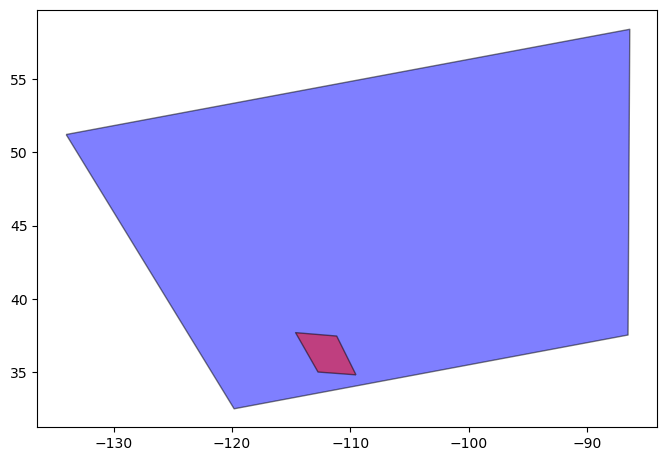

In [43]:
# Plot them together
fig, ax = plt.subplots(figsize=(8, 8))
viirs_bound_poly.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5, label='Polygon 1')
AOI.plot(ax=ax, color='red', edgecolor='black', alpha=0.5, label='Polygon 2')

In [44]:
AOI.bounds

,minx,miny,maxx,maxy
0,-114.672016,34.856997,-109.558228,37.735246


In [45]:
def combine_viirs_images(input_dir, output_dir):
    """
    Combine two VIIRS images using Satpy, slicing them, and save the output.

    Parameters:
        input_dir (str): Directory containing VIIRS image files.
        output_dir (str): Directory where the combined image will be saved.

    Returns:
        None
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Locate VIIRS files
    viirs_files = glob(os.path.join(input_dir, "*.nc"))
    if len(viirs_files) < 2:
        raise ValueError("At least two VIIRS files are required for combining.")

    # Load files into a Satpy Scene
    scene = Scene(reader="viirs_l1b", filenames=viirs_files[:2])

    # Load all available datasets
    scene.load(scene.available_dataset_names())
    print(scene.available_dataset_names())

    target_area = "goes_east_abi_c_500m"
    combined_scene = scene.resample(target_area, resampler="nearest")

    # Save datasets as GeoTIFFs
    my_bands = ["I04", "I05"]
    band_data_list = []
    for band in my_bands:
        band_data = combined_scene[band].values  # Extract values
        band_data_list.append(band_data)

    # Combine the bands into a single 3D array (bands, y, x)
    combined_bands = np.stack(band_data_list, axis=0)

    # Wrap the combined data into an xarray DataArray with rioxarray extension
    combined_data_rio = xr.DataArray(
        combined_bands,
        dims=["band", "y", "x"],
        coords={
            "band": [1, 2],  # Band indices
            "y": combined_scene["I04"].y,
            "x": combined_scene["I04"].x
        },
        attrs=combined_scene["I04"].attrs,  # Copy CRS and attributes
    )
    combined_data_rio.rio.write_crs(combined_scene["I04"].attrs["area"].crs.to_string(), inplace=True)

    # Save the combined GeoTIFF
    output_tif = os.path.join(output_dir, "combined_bands.tif")
    combined_data_rio.rio.to_raster(output_tif)
    print(f"Combined file with both bands saved at {output_tif}")

In [46]:
combine_viirs_images(r"C:\Users\Admin\Desktop\6.3.25\2020-02-20_19-54",r"C:\Users\Admin\Desktop\6.3.25\2020-02-20_19-54")

Don't know how to open the following files: {'C:\\Users\\Admin\\Desktop\\6.3.25\\2020-02-20_19-54\\OR_ABI-L2-MCMIPC-M6_G16_s20200511956158_e20200511958531_c20200511959088.nc'}
Required file type 'vgeoi' not found or loaded for 'i_lon'
Required file type 'vgeoi' not found or loaded for 'i_lat'
Failed to load coordinates for 'DataID(name='I03', wavelength=WavelengthRange(min=1.58, central=1.61, max=1.64, unit='µm'), resolution=371, calibration=<calibration.reflectance>, modifiers=())'
Failed to load coordinates for 'DataID(name='I02', wavelength=WavelengthRange(min=0.845, central=0.865, max=0.884, unit='µm'), resolution=371, calibration=<calibration.reflectance>, modifiers=())'
Failed to load coordinates for 'DataID(name='I04', wavelength=WavelengthRange(min=3.58, central=3.74, max=3.9, unit='µm'), resolution=371, calibration=<calibration.brightness_temperature>, modifiers=())'
Failed to load coordinates for 'DataID(name='I05', wavelength=WavelengthRange(min=10.5, central=11.45, max=12.3

['I01', 'I02', 'I03', 'I04', 'I05']


KeyError: 'area'

In [54]:
combined = r"C:\Users\Admin\Desktop\6.3.25\2020-02-20_19-54\combined_bands.tif"
img = rioxarray.open_rasterio(combined)
img.rio.crs

CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown based on GRS 1980 ellipsoid",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",-75],PARAMETER["satellite_height",35786023],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=geos +sweep=x +lon_0=-75 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs"]]')

In [55]:
AOI = AOI.to_crs(img.rio.crs)

In [56]:
img_clip = img.rio.clip(AOI.geometry)

In [69]:
img_clip[1].values

array([[  287.5488 ,   287.87006,   288.88257, ...,   291.77576,
          290.43063,   289.91794],
       [  288.14243,   288.83487,   288.73938, ...,   292.45963,
          290.36472,   289.42197],
       [  287.83475,   287.57132,   287.8572 , ...,   291.409  ,
          290.9224 ,   291.521  ],
       ...,
       [  301.00693,   298.39264,   299.90424, ..., 65535.     ,
        65535.     , 65535.     ],
       [  299.47043,   299.95944,   300.56235, ..., 65535.     ,
        65535.     , 65535.     ],
       [  299.70062,   300.13657,   300.0524 , ..., 65535.     ,
        65535.     , 65535.     ]], dtype=float32)

In [1]:
import rioxarray
import os

# List of image files to check
image_files = [
    "clipped_geo16.tif",
    "clipped_geo17.tif",
    "combined_clip.tif"
]

# Function to get image size (in pixels)
def get_image_size(image_path):
    try:
        img = rioxarray.open_rasterio(image_path)
        height, width = img.shape[-2:]  # Get dimensions (y, x)
        num_bands = img.shape[0]  # Number of bands
        print(f"Image: {os.path.basename(image_path)}")
        print(f"  - Bands: {num_bands}")
        print(f"  - Size: {height} x {width} pixels (Height x Width)\n")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Run on all images
for img_file in image_files:
    get_image_size(img_file)


Image: clipped_geo16.tif
  - Bands: 32
  - Size: 100 x 100 pixels (Height x Width)

Image: clipped_geo17.tif
  - Bands: 32
  - Size: 100 x 100 pixels (Height x Width)

Image: combined_clip.tif
  - Bands: 2
  - Size: 400 x 400 pixels (Height x Width)



C:\Users\Admin\anaconda3\envs\sat_project_py3.9\lib\site-packages\rioxarray\_io.py:669: UserWarning: Offsets differ across bands. The 'scale_factor' attribute will not be added. See the 'scales' attribute.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\sat_project_py3.9\lib\site-packages\rioxarray\_io.py:678: UserWarning: Offsets differ across bands. The 'add_offset' attribute will not be added. See the 'offsets' attribute.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\sat_project_py3.9\lib\site-packages\rioxarray\_io.py:669: UserWarning: Offsets differ across bands. The 'scale_factor' attribute will not be added. See the 'scales' attribute.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\sat_project_py3.9\lib\site-packages\rioxarray\_io.py:678: UserWarning: Offsets differ across bands. The 'add_offset' attribute will not be added. See the 'offsets' attribute.
  warnings.warn(


In [8]:
G16 = rioxarray.open_rasterio("OR_ABI-L2-MCMIPC-M6_G16_s20200572116150_e20200572118529_c20200572119076.nc")
G16_CRS = G16.rio.crs
print(G16_CRS)

PROJCS["unnamed",GEOGCS["unknown",DATUM["unnamed",SPHEROID["Spheroid",6378137,298.2572221]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",-75],PARAMETER["satellite_height",35786023],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=geos +lon_0=-75 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs +sweep=x"]]


In [5]:
import os
import re
import gc
import geopandas as gpd
import rioxarray

# Define paths for test:
order_path = r"W:\Sat_Project\Test_Folder"
AOI_PATH = r"shape_files/boundary_gdf.shp"
AOY_PATH = r"shape_files/boundary_gdf.shp"

# Load AOI
aoi = gpd.read_file(AOY_PATH)

# Paths to test GOES images
goes_files = [
    "OR_ABI-L2-MCMIPC-M6_G16_s20200572116150_e20200572118529_c20200572119076.nc",
    "OR_ABI-L2-MCMIPC-M6_G17_s20200572116179_e20200572118564_c20200572119088.nc"
]

# Sort to ensure G16 is first
goes_files.sort(key=lambda x: "G16" not in x)

reference_raster = None
reference_AOI_geo = None

AOI_PATH = r"shape_files/boundary_gdf.shp"
AOI = gpd.read_file(AOI_PATH)

for file in goes_files:
    file_path = os.path.join(order_path, file)
    print(f"Opened GOES image: {file}")

    try:
        with rioxarray.open_rasterio(file_path, masked=True) as ds:
            img = ds.squeeze()

            if "G16" in file:
                print(f"Setting {file} as reference raster")
                reference_raster = img.copy()
                reference_AOI_geo = AOI.to_crs(img.rio.crs)
                print(f"Reprojected AOI to match GOES-16 CRS: {reference_AOI_geo.crs}")

            elif "G17" in file and reference_raster is not None:
                print(f"Reprojecting {file} to match GOES-16 grid")
                img = img.rio.reproject_match(reference_raster)

            geo_clip = img.rio.clip(reference_AOI_geo.geometry, all_touched=True)

            match = re.search(r"G(\d{2})", file)
            num = match.group(1) if match else None
            if num:
                output_tif = os.path.join(order_path, f"clipped_geo{num}.tif")
                geo_clip.rio.to_raster(output_tif)
                print(f"✅ Saved clipped image: {output_tif}")
            else:
                raise ValueError(f"⚠ Warning: Could not extract GOES number from {file}")

    except Exception as e:
        print(f"❌ Error processing {file}: {e}")

    finally:
        gc.collect()  # Clean up file handles

Opened GOES image: OR_ABI-L2-MCMIPC-M6_G16_s20200572116150_e20200572118529_c20200572119076.nc
❌ Error processing OR_ABI-L2-MCMIPC-M6_G16_s20200572116150_e20200572118529_c20200572119076.nc: W:\Sat_Project\Test_Folder\OR_ABI-L2-MCMIPC-M6_G16_s20200572116150_e20200572118529_c20200572119076.nc: No such file or directory
Opened GOES image: OR_ABI-L2-MCMIPC-M6_G17_s20200572116179_e20200572118564_c20200572119088.nc
❌ Error processing OR_ABI-L2-MCMIPC-M6_G17_s20200572116179_e20200572118564_c20200572119088.nc: W:\Sat_Project\Test_Folder\OR_ABI-L2-MCMIPC-M6_G17_s20200572116179_e20200572118564_c20200572119088.nc: No such file or directory


In [4]:
import os
import re
import gc
import geopandas as gpd
import rioxarray

# Define paths for test:
order_path = r"W:\Sat_Project\Test_Folder"
AOI_PATH = r"shape_files/boundary_gdf.shp"

# Load AOI
aoi = gpd.read_file(AOY_PATH)

# Paths to test GOES images
goes_files = [
    "OR_ABI-L2-MCMIPC-M6_G16_s20200572116150_e20200572118529_c20200572119076.nc",
    "OR_ABI-L2-MCMIPC-M6_G17_s20200572116179_e20200572118564_c20200572119088.nc"
]

# Sort to ensure G16 is first
goes_files.sort(key=lambda x: "G16" not in x)

reference_raster = None
reference_AOI_geo = None

AOI_PATH = r"shape_files/boundary_gdf.shp"
AOI = gpd.read_file(AOI_PATH)

for file in goes_files:
    file_path = os.path.join(order_path, file)
    print(f"Opened GOES image: {file}")

    try:
        with rioxarray.open_rasterio(file_path, masked=True) as ds:
            img = ds.squeeze()

            if "G16" in file:
                print(f"Setting {file} as reference raster")
                reference_raster = img.copy()
                reference_AOI_geo = AOI.to_crs(img.rio.crs)
                print(f"Reprojected AOI to match GOES-16 CRS: {reference_AOI_geo.crs}")

            elif "G17" in file and reference_raster is not None:
                print(f"Reprojecting {file} to match GOES-16 grid")
                img = img.rio.reproject_match(reference_raster)

            geo_clip = img.rio.clip(reference_AOI_geo.geometry, all_touched=True)

            match = re.search(r"G(\d{2})", file)
            num = match.group(1) if match else None
            if num:
                output_tif = os.path.join(order_path, f"clipped_geo{num}.tif")
                geo_clip.rio.to_raster(output_tif)
                print(f"✅ Saved clipped image: {output_tif}")
            else:
                raise ValueError(f"⚠ Warning: Could not extract GOES number from {file}")

    except Exception as e:
        print(f"❌ Error processing {file}: {e}")

    finally:
        gc.collect()  # Clean up file handles

NameError: name 'AOY_PATH' is not defined

In [1]:
import os
import shutil

# The four files to check
REQUIRED_FILES = [
    "combined_clip.tif",
    "clipped_geo16.tif",
    "clipped_geo17.tif",
    "clipped_geo18.tif"
]

# Paths to your 'INVALID' and 'VALID' directories
invalid_root = r"W:\Sat_Project\Processed\INVALID"
valid_root   = r"W:\Sat_Project\Processed\VALID"

def fix_invalid_folders():
    """
    Re-checks each order folder in 'INVALID'.
    If it has at least 3 of the 4 required files,
    it moves it to 'VALID'.
    """
    for month_folder in os.listdir(invalid_root):
        month_path = os.path.join(invalid_root, month_folder)

        # Skip anything that's not a directory
        if not os.path.isdir(month_path):
            continue

        for order_folder in os.listdir(month_path):
            order_path = os.path.join(month_path, order_folder)
            if not os.path.isdir(order_path):
                continue

            # Count how many of the 4 we have
            count = 0
            for filename in REQUIRED_FILES:
                if os.path.exists(os.path.join(order_path, filename)):
                    count += 1

            if count >= 3:
                # Means we have 3 out of the 4 => now valid
                new_month_path = os.path.join(valid_root, month_folder)
                os.makedirs(new_month_path, exist_ok=True)
                shutil.move(order_path, new_month_path)
                print(f"✅ Moved '{order_folder}' from INVALID to VALID "
                      f"(found {count} of 4 required files)")
            else:
                print(f"Still invalid: '{order_folder}' with only {count} of 4 required files.")

if __name__ == '__main__':
    fix_invalid_folders()
    print("✅ Done re-checking invalid folders.")


Still invalid: '2020-02-20_19-48' with only 0 of 4 required files.
Still invalid: '2020-02-20_19-54' with only 1 of 4 required files.
Still invalid: '2020-02-20_21-30' with only 0 of 4 required files.
Still invalid: '2020-02-20_21-36' with only 0 of 4 required files.
Still invalid: '2020-02-21_19-30' with only 0 of 4 required files.
Still invalid: '2020-02-21_19-36' with only 0 of 4 required files.
Still invalid: '2020-02-21_21-18' with only 0 of 4 required files.
Still invalid: '2020-02-22_19-12' with only 0 of 4 required files.
Still invalid: '2020-02-23_18-54' with only 0 of 4 required files.
Still invalid: '2020-02-25_19-54' with only 0 of 4 required files.
Still invalid: '2020-02-25_21-36' with only 0 of 4 required files.
Still invalid: '2020-02-25_21-42' with only 0 of 4 required files.
Still invalid: '2020-02-26_19-36' with only 0 of 4 required files.
Still invalid: '2020-02-26_19-42' with only 0 of 4 required files.
Still invalid: '2020-02-26_21-24' with only 0 of 4 required fi

In [4]:
import xarray as xr

file = r"W:\Sat_Project\Processed\VALID\2022-12\2022-12-06_19-30\OR_ABI-L2-MCMIPC-M6_G16_s20223401931175_e20223401933555_c20223401934056.nc"
ds = xr.open_dataset(file)

print(ds)  # or ds.attrs for metadata


<xarray.Dataset> Size: 480MB
Dimensions:                                 (y: 1500, x: 2500,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] 8B ...
  * y                                       (y) float32 6kB 0.1282 ... 0.04427
  * x                                       (x) float32 10kB -0.1013 ... 0.03861
    y_image                                 float32 4B ...
    x_image                                 float32 4B ...
    band_wavelength_C01                     (band) float32 4B ...
    ...                                      ...
    band_id_C11                             (band) int8 1B ...
    band_id_C12                             (band) int8 1B ...
    band_id_C13                             (band) int8 1B ...
    band_id_C14                             (band) int8 1B ...
    band_id_C15         